## 3C - L3 Camera Calibration

In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import pytransform3d.rotations as pr
from pytransform3d.plot_utils import plot_vector

np.random.seed(42)

### Helper Functions

In [2]:
def get_rot_x(angle):
    '''
    transformation matrix that rotates a point about the standard X axis
    '''
    Rx = np.zeros(shape=(3, 3))
    Rx[0, 0] = 1
    Rx[1, 1] = np.cos(angle)
    Rx[1, 2] = -np.sin(angle)
    Rx[2, 1] = np.sin(angle)
    Rx[2, 2] = np.cos(angle)
    
    return Rx

def get_rot_y(angle):
    '''
    transformation matrix that rotates a point about the standard Y axis
    '''
    Ry = np.zeros(shape=(3, 3))
    Ry[0, 0] = np.cos(angle)
    Ry[0, 2] = -np.sin(angle)
    Ry[2, 0] = np.sin(angle)
    Ry[2, 2] = np.cos(angle)
    Ry[1, 1] = 1
    
    return Ry

def get_rot_z(angle):
    '''
    transformation matrix that rotates a point about the standard Z axis
    '''
    Rz = np.zeros(shape=(3, 3))
    Rz[0, 0] = np.cos(angle)
    Rz[0, 1] = -np.sin(angle)
    Rz[1, 0] = np.sin(angle)
    Rz[1, 1] = np.cos(angle)
    Rz[2, 2] = 1
    
    return Rz

In [3]:
def create_rotation_transformation_matrix(angles, order):
    '''
    Create a matrix that rotates a vector through the given angles in the given order
    wrt the standard global axes (extrinsic rotation)
    Note: The rotation is carried out anticlockwise in a left handed axial system
    
    Parameters
    -----------
    angles - list
        list of angles in radians
    order - string
        the order in which to rotate
        
    Returns
    --------
    net - np.ndarray, shape - (3, 3)
        The transformation matrix which carries out the given rotations
    '''
    fn_mapping = {'x': get_rot_x, 'y': get_rot_y, 'z': get_rot_z}
    net = np.identity(3)
    for angle, axis in list(zip(angles, order))[::-1]:
        if fn_mapping.get(axis) is None:
            raise ValueError("Invalid axis")
        R = fn_mapping.get(axis)
        net = np.matmul(net, R(angle))
        
    return net

In [4]:
def create_translation_matrix(offset):
    '''
    Create a transformation matrix that translates a vetor by the given offset
    
    Parameters
    -----------
    offset - np.ndarray, shape - (3,)
        The translation offset
    
    Returns
    ----------
    T - np.ndarray, shape - (4, 4)
        The translation matrix
    '''
    T = np.identity(4)
    T[:3, 3] = offset
    return T

In [5]:
def create_rotation_change_of_basis_matrix(transformation_matrix):
    '''
    Creates a rotation change of basis matrix
    '''
    # basis vectors
    x = np.array([1, 0, 0])
    y = np.array([0, 1, 0])
    z = np.array([0, 0, 1])
    
    xt = transformation_matrix.T @ x.reshape(3, 1)
    yt = transformation_matrix.T @ y.reshape(3, 1)
    zt = transformation_matrix.T @ z.reshape(3, 1)
    
    return np.hstack((xt, yt, zt))

In [6]:
def transform_image_plane(T, img_size, f):
    '''
    Transform the image plane with the given transformation matrix
    '''
    h, w = img_size
    xx, yy = np.meshgrid(range(-(h // 2), w // 2 + 1), range(-(h // 2), w // 2 + 1))
    Z = np.ones(shape=img_size) * f
    
    # extract points from the image plane grid
    pi = np.ones(shape=(4, h*w))
    c = 0
    for i in range(h):
        for j in range(w):
            x = xx[i, j]
            y = yy[i, j]
            z = Z[i, j]
            point = np.array([x, y, z])
            pi[:3, c] = point
            c += 1
    
    pt = np.matmul(T, pi)
    
    # separate x, y, z and construct a grid from the transformed points
    xxt = pt[0, :].reshape(img_size)
    yyt = pt[1, :].reshape(img_size)
    Zt = pt[2, :].reshape(img_size)
    
    return xxt, yyt, Zt

In [7]:
def generate_random_points(n_points, xlim, ylim, zlim):
    x = np.random.randint(xlim[0], xlim[1], size=n_points)
    y = np.random.randint(ylim[0], ylim[1], size=n_points)
    z = np.random.randint(zlim[0], zlim[1], size=n_points)
    
    return np.vstack((x, y, z))

In [8]:
def compute_intrinsic_parameter_matrix(f, s, a, cx, cy):
    K = np.identity(3)
    K[0, 0] = f
    K[0, 1] = s
    K[0, 2] = cx
    K[1, 1] = a * f
    K[1, 2] = cy
    
    return K

In [9]:
def compute_world2img_projection(points, E, K):
        
    P = np.identity(4)[:3, :] # the projection matrix
    h_points_i = K @ P @ E @ points
    
    h_points_i[0, :] = h_points_i[0, :] / h_points_i[2, :]
    h_points_i[1, :] = h_points_i[1, :] / h_points_i[2, :]

    points_i = h_points_i[:2, :]    
    
    return points_i

In [10]:
def create_rotation_change_of_basis_matrix(transformation_matrix):
    '''
    Creates a rotation change of basis matrix
    '''
    # basis vectors
    x = np.array([1, 0, 0])
    y = np.array([0, 1, 0])
    z = np.array([0, 0, 1])
    
    xt = transformation_matrix.T @ x.reshape(3, 1)
    yt = transformation_matrix.T @ y.reshape(3, 1)
    zt = transformation_matrix.T @ z.reshape(3, 1)
    
    return np.hstack((xt, yt, zt))

In [11]:
make_line = lambda u, v: np.vstack((u, v)).T

In [12]:
# create the transformation matrix

angles = [np.pi/4]
order = 'y'

R = create_rotation_transformation_matrix(angles, order)
R_ = np.identity(4)
R_[:3, :3] = R

# create translation matrix
offset = np.array([0, -0.5, 0])
O = create_translation_matrix(offset)

T = np.matmul(R_, O)

In [13]:
f = 2
img_size = (10, 10)

# basis in homogeneous coordinates
xh = np.array([1, 0, 0, 1])
yh = np.array([0, 1, 0, 1])
zh = np.array([0, 0, 1, 1])
origin = np.array([0, 0, 0])

# transform the image plane
xxt, yyt, Zt = transform_image_plane(T, img_size, f)

In [14]:
# Generate random points
z_ = np.array([0, 0, f, 1]).reshape(4, 1)
z_llim = (T @ z_)[2]

In [15]:
n_points = 12
rand_points = generate_random_points(n_points, (-10, 0), (-10, 10), (z_llim, 10))

In [16]:
# create extrinsic camera matrix
Rc = create_rotation_change_of_basis_matrix(R)
E = np.identity(4)
E[:3, :3] = Rc
E[:3, 3] = -offset

In [17]:
# convert rand points to homogeneous coordinates
rand_points_h = np.ones(shape=(4, n_points))
for i in range(n_points):
    point = rand_points[:, i]
    rand_points_h[:3, i] = point

In [18]:
K = compute_intrinsic_parameter_matrix(f, 0, 1, 0, 0)

In [19]:
projections = compute_world2img_projection(rand_points_h, E, K)

In [20]:
projections

array([[-0.28571429,  0.        ,  0.28571429,  0.4       , -0.28571429,
         1.33333333, -0.90909091,  0.54545455,  0.5       ,  0.4       ,
         0.        , -0.4       ],
       [-3.03045763, -1.71725933,  0.60609153, -0.84852814, -3.43451865,
        -4.47834295,  0.38569461,  0.38569461,  2.29809704, -0.0942809 ,
         1.1111678 ,  2.54558441]])

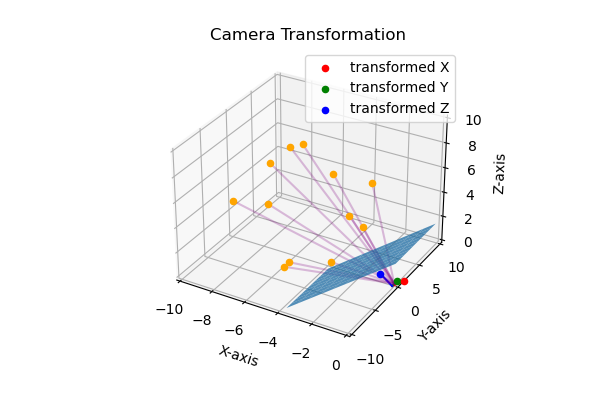

In [21]:
# plot the transformed camera and image plane

# create figure
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111,projection='3d')

# set axis limits
ax.set(xlim=(-10, 0), ylim=(-10, 10), zlim=(0, 10))

# plot the transformed basis using the library
ax = pr.plot_basis(ax, R, p=offset)

# plot the image plane
ax.plot_surface(xxt, yyt, Zt, alpha=0.75)

# transform the basis points using the transformation matrix
xt = T @ xh.reshape(4, 1)
yt = T @ yh.reshape(4, 1)
zt = T @ zh.reshape(4, 1)

ax.scatter(*xt.flatten()[:3], label="transformed X", color="red")
ax.scatter(*yt.flatten()[:3], label="transformed Y", color="green")
ax.scatter(*zt.flatten()[:3], label="transformed Z", color="blue")

# plot points
for i in range(n_points):
    point = rand_points[:, i]
    ax.scatter(*point, color="orange")
    ax.plot(*make_line(origin, point), color="purple", alpha=0.25)

# set labels
ax.set_title("Camera Transformation")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

plt.legend()

In [22]:
projections

array([[-0.28571429,  0.        ,  0.28571429,  0.4       , -0.28571429,
         1.33333333, -0.90909091,  0.54545455,  0.5       ,  0.4       ,
         0.        , -0.4       ],
       [-3.03045763, -1.71725933,  0.60609153, -0.84852814, -3.43451865,
        -4.47834295,  0.38569461,  0.38569461,  2.29809704, -0.0942809 ,
         1.1111678 ,  2.54558441]])

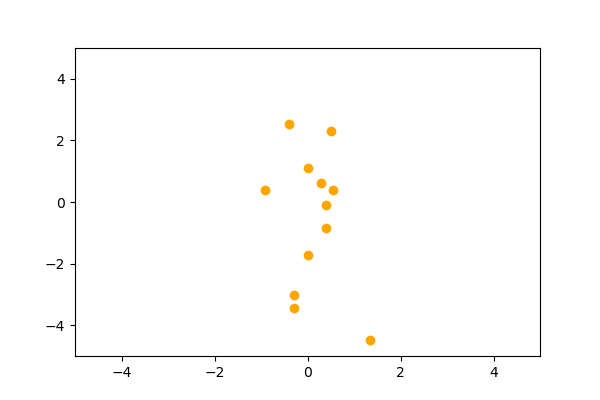

In [23]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)

h, w = img_size
ax.set(xlim = (-(h // 2), w // 2), ylim = (-(h // 2), w // 2))
for i in range(n_points):
        ax.scatter(*projections[:, i], color="orange")

In [24]:
rand_points.shape, projections.shape

((3, 12), (2, 12))

In [25]:
P = np.identity(4)[:3, :] # the projection matrix
M = K @ P @ E

In [26]:
M

array([[ 1.41421356,  0.        ,  1.41421356,  0.        ],
       [ 0.        ,  2.        ,  0.        ,  1.        ],
       [-0.70710678,  0.        ,  0.70710678,  0.        ]])

In [27]:
def create_algebraic_matrix(world_point, projection_point):
    X, Y, Z = world_point
    u, v = projection_point
    rows = np.zeros(shape=(2, 12))
    
    rows[0, 0], rows[0, 1], rows[0, 2], rows[0, 3] = X, Y, Z, 1
    rows[0, 8], rows[0, 9], rows[0, 10], rows[0, 11] = -u * X, -u * Y, -u * Z, -u
    
    rows[1, 4], rows[1, 5], rows[1, 6], rows[1, 7] = X, Y, Z, 1
    rows[1, 8], rows[1, 9], rows[1, 10], rows[1, 11] = -v * X, -v * Y, -v * Z, -v
    
    return rows

In [28]:
A = np.ones(shape=(2*n_points, 12))

In [29]:
c = 0
for i in range(n_points):
    w = rand_points[:, i]
    p = projections[:, i]
    A[c:c+2, :] = create_algebraic_matrix(w, p)
    c += 2

In [30]:
A.shape

(24, 12)

In [31]:
V = np.matmul(A.T, A)

In [32]:
V.shape

(12, 12)

In [33]:
w, v = np.linalg.eig(V)

In [34]:
m = v[:, 11]

In [35]:
m

array([ 0.15130928, -0.0041094 ,  0.1409516 ,  0.04735786, -0.09241255,
        0.20945429,  0.05869871, -0.93729794, -0.07962174, -0.02476708,
        0.06896977, -0.0942576 ])

In [68]:
M_ = m.reshape(3, 4)

In [75]:
predictions = np.matmul(M_, rand_points_h)

In [76]:
predictions[0, :] = predictions[0, :] / predictions[2, :]
predictions[1, :] = predictions[1, :] / predictions[2, :]

predictions = predictions[:2, :]  

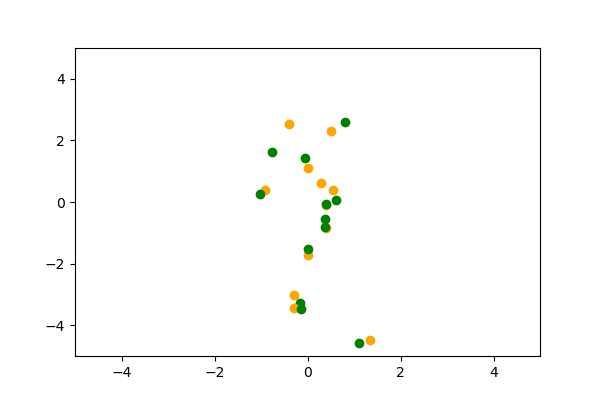

In [77]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)

h, w = img_size
ax.set(xlim = (-(h // 2), w // 2), ylim = (-(h // 2), w // 2))
for i in range(n_points):
        ax.scatter(*projections[:, i], color="orange")
        ax.scatter(*predictions[:, i], color="green")

In [64]:
projections

array([[-0.28571429,  0.        ,  0.28571429,  0.4       , -0.28571429,
         1.33333333, -0.90909091,  0.54545455,  0.5       ,  0.4       ,
         0.        , -0.4       ],
       [-3.03045763, -1.71725933,  0.60609153, -0.84852814, -3.43451865,
        -4.47834295,  0.38569461,  0.38569461,  2.29809704, -0.0942809 ,
         1.1111678 ,  2.54558441]])

In [65]:
predictions

array([[-2.85684888e-01,  5.84402232e-07,  2.85726794e-01,
         3.99999151e-01, -2.85683477e-01,  1.33333285e+00,
        -9.09090246e-01,  5.45457763e-01,  5.00007155e-01,
         3.99998299e-01, -6.50927062e-06, -3.99969230e-01],
       [-3.03044118e+00, -1.71725502e+00,  6.06058253e-01,
        -8.48521536e-01, -3.43449095e+00, -4.47829735e+00,
         3.85696944e-01,  3.85698152e-01,  2.29809574e+00,
        -9.42670722e-02,  1.11119597e+00,  2.54549324e+00]])

In [66]:
M

array([[ 1.41421356,  0.        ,  1.41421356,  0.        ],
       [ 0.        ,  2.        ,  0.        ,  1.        ],
       [-0.70710678,  0.        ,  0.70710678,  0.        ]])

In [67]:
M__

array([[ 1.40140443e-01, -4.97045077e-07,  1.40137177e-01,
         1.89599142e-05],
       [-4.02563547e-06,  1.98187154e-01,  3.90777294e-06,
         9.90500305e-02],
       [-7.00683948e-02, -6.82876608e-07,  7.00674854e-02,
         1.45327642e-05]])

In [51]:
def geometric_error(m):
#     n_points = kwargs.get("n_points")
#     world_points = kwargs.get("world_points")
#     projections = kwargs.get("projections")
#     m_ = np.ones(12)
    error = 0
    for i in range(n_points):
        X, Y, Z = rand_points[:, i]
        u, v = projections[:, i]
        u_ = m[0] * X + m[1] * Y + m[2] * Z + m[3]
        v_ = m[4] * X + m[5] * Y + m[6] * Z + m[7]
        d = m[8] * X + m[9] * Y + m[10] * Z + m[11] 
        u_ = u_/d
        v_ = v_/d
        error += np.sqrt(np.square(u - u_) + np.square(v - v_))
    return error
        

In [52]:
from scipy.optimize import least_squares, minimize

In [53]:
arg_dict={"n_points": n_points, "world_points": rand_points, "projections": projections}

In [54]:
geometric_error(m, n_points=n_points, world_points=rand_points, projections=projections)

TypeError: geometric_error() got an unexpected keyword argument 'n_points'

In [55]:
result = least_squares(geometric_error, m, method='lm', kwargs=arg_dict)

TypeError: geometric_error() got an unexpected keyword argument 'n_points'

In [56]:
result.x

NameError: name 'result' is not defined

In [57]:
result.cost

NameError: name 'result' is not defined

In [58]:
result.optimality

0.3443455700121499

In [57]:
result.status

0

In [58]:
result = minimize(geometric_error, m)

In [59]:
M__ = result.x

In [60]:
M__ = M__.reshape(3, 4)

In [77]:
M

array([[ 1.41421356,  0.        ,  1.41421356,  0.        ],
       [ 0.        ,  2.        ,  0.        ,  1.        ],
       [-0.70710678,  0.        ,  0.70710678,  0.        ]])

In [78]:
M__


array([[ 1.40140443e+00, -4.97045077e-06,  1.40137177e+00,
         1.89599142e-04],
       [-4.02563547e-05,  1.98187154e+00,  3.90777294e-05,
         9.90500305e-01],
       [-7.00683948e-01, -6.82876608e-06,  7.00674854e-01,
         1.45327642e-04]])